# ERP v. Rotation
Event-related potential (ERP) v. spectral rotation (exponent shift). This notebooks demonstrates the difference between an ERP and a spectral rotation by plotting data from a couple example electrodes: one with an ERP and no exponent shift, and another with an exponent shift and no ERP

## Set-up

### Imports

In [1]:
# general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne import read_epochs

from specparam import SpectralGroupModel, fit_models_3d

In [2]:
# custom
import sys
sys.path.append(f"../code")
from paths import PROJECT_PATH
from info import FS, PATIENTS
from settings import (BANDS, SPEC_PARAM_SETTINGS, WINDOW, TFR_METHOD, 
    N_TFR_SAMPLES, N_JOBS, FREQ_RANGE, RGB)
from erp_utils import compute_erp, plot_event_traces
from tfr_utils import crop_tfr, subtract_baseline
from specparam_utils import extract_ap_params

### Settings

In [3]:
# set plotting style
plt.style.use("../mplstyle/default.mplstyle")

In [4]:
# settings
T_BASELINE = [-0.5, 0.] # baseline time window for ERP computation
T_TRIM = [-0.5, 1.] # time window to trim signal

### Functions

In [5]:
def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio
    source: https://stackoverflow.com/questions/10481990/matplotlib-axis-with-two-scales-shared-origin
    """
    
    # Get y-axis range of each plot
    axes = np.array([ax1, ax2])
    extrema = np.array([ax.get_ylim() for ax in axes])
    tops = extrema[:,1] / (extrema[:,1] - extrema[:,0])

    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [a[::-1] for a in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    # Rescale each plot
    extrema[0,1] = extrema[0,0] + tot_span * (extrema[0,1] - extrema[0,0])
    extrema[1,0] = extrema[1,1] + tot_span * (extrema[1,0] - extrema[1,1])
    for i in range(2):
        axes[i].set_ylim(*extrema[i])


### Create output directory

In [6]:
path_out = f"{PROJECT_PATH}/figures/supporting_figures/erp_v_rotation"
if not os.path.exists(path_out):
    os.makedirs(path_out)

## Main

### Compute ERP and exponent time-series

In [7]:
# Set example channels
#  NOTE: ERP plots were visually scanned to identify channels with large ERPs

PATIENT = ['pat19', 'pat05']
CHAN_IDX = [66, 48]
MATERIAL = ['faces', 'faces']
MEMORY = ['miss', 'hit']


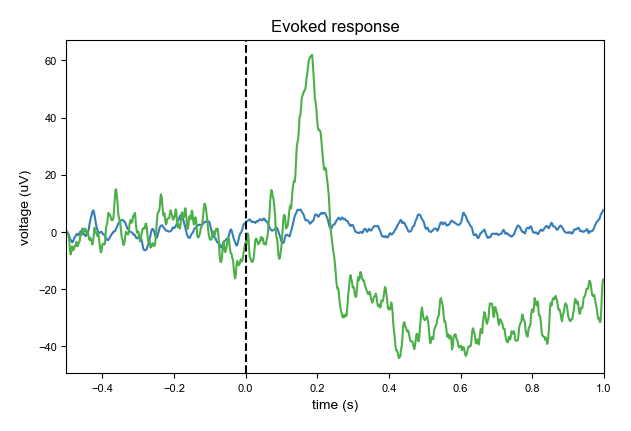

In [9]:
# compute erp and plot

# init
erp_list = []

# create fig
fig, ax = plt.subplots(1,1, figsize=[6,4])

# loop through conditions
for i_cond, color in zip(range(len(CHAN_IDX)), [RGB[2], RGB[1]]):
    # load epochs
    fname_in = f"{PROJECT_PATH}/data/ieeg_epochs/{PATIENT[i_cond]}_{MATERIAL[i_cond]}_{MEMORY[i_cond]}_epo.fif"
    epochs = read_epochs(fname_in, verbose=False)

    # compute erp
    signals = epochs.get_data(copy=True)
    erp_time = epochs.times
    erps = compute_erp(signals, erp_time, T_BASELINE)

    # trim signal
    erps, erp_time = crop_tfr(erps, erp_time, T_TRIM)

    # plot
    ax.plot(erp_time, erps[CHAN_IDX[i_cond]], color=color)

    # store
    erp_list.append(erps[CHAN_IDX[i_cond]])

# label / format
ax.set(xlabel=f'time (s)', ylabel=f'voltage (uV)')
ax.set_title('Evoked response')
ax.axvline(0, color='k', linestyle='--')
ax.set_xlim(T_TRIM)
plt.show()


Reading C:\Users\micha\projects\oscillation_vs_exponent\data\ieeg_epochs\pat19_faces_miss_epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms


        0 CTF compensation matrices available
Adding metadata with 5 columns
49 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\micha\projects\oscillation_vs_exponent\data\ieeg_epochs\pat05_faces_hit_epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns


C:\Users\micha\AppData\Local\Temp\ipykernel_23240\3394673233.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  signals = epochs.get_data()[:, CHAN_IDX[i_cond]]


66 matching events found
No baseline correction applied
0 projection items activated


C:\Users\micha\AppData\Local\Temp\ipykernel_23240\3394673233.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  signals = epochs.get_data()[:, CHAN_IDX[i_cond]]


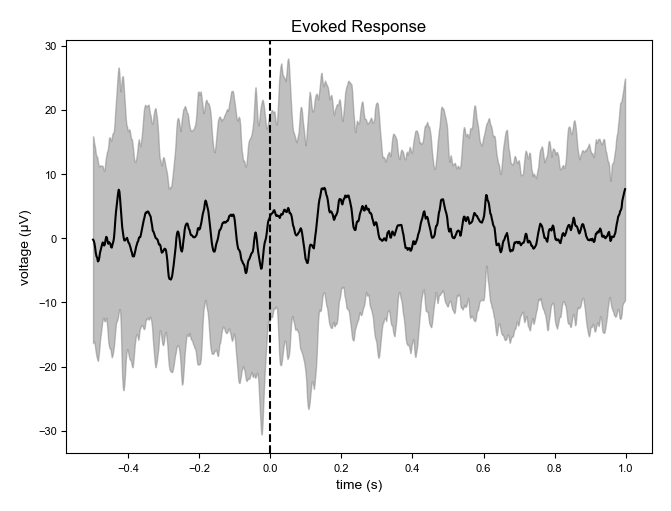

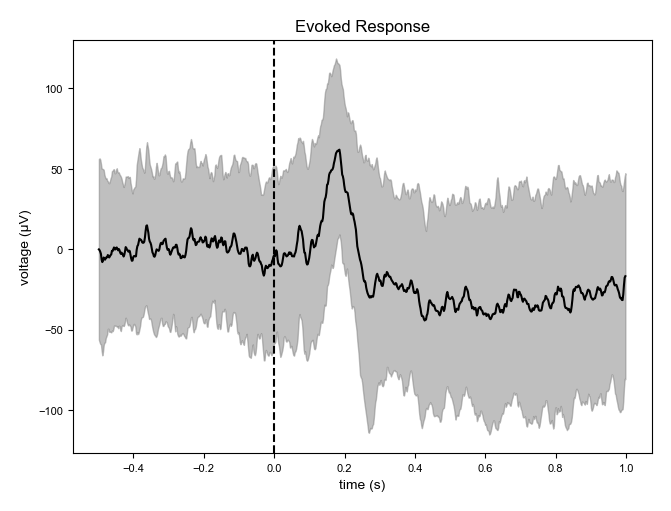

In [10]:
# compute erp and plot

# init
erp_list = []

# loop through conditions
for i_cond in range(len(CHAN_IDX)):
    # load epochs
    fname_in = f"{PROJECT_PATH}/data/ieeg_epochs/{PATIENT[i_cond]}_{MATERIAL[i_cond]}_{MEMORY[i_cond]}_epo.fif"
    epochs = read_epochs(fname_in)

    # get event traces
    signals = epochs.get_data()[:, CHAN_IDX[i_cond]]
    erp_time = epochs.times

    # remove nan trials
    signals = signals[~np.isnan(signals).any(axis=1)]

    # subtract baseline
    for i_trial in range(signals.shape[0]):
        signals[i_trial] = signals[i_trial] - np.mean(signals[i_trial,((erp_time >= T_BASELINE[0]) & (erp_time <= T_BASELINE[1]))])

    # trim signal
    erps, erp_time = crop_tfr(signals, erp_time, T_TRIM)

    # plot
    plot_event_traces(erps, erp_time, ax=ax)

    # store
    erp_list.append(erps)

# label / format
ax.set(xlabel=f'time (s)', ylabel=f'voltage (uV)')
ax.set_title('Evoked response')
ax.axvline(0, color='k', linestyle='--')
ax.set_xlim(T_TRIM)
plt.show()


In [11]:
# # compute time-resolved spectral parameters

# exp_list = []
# for i_cond in range(len(CHAN_IDX)):
#     print(f"\nCondition {i_cond+1} of {len(CHAN_IDX)}")
    
#     # load tfr
#     fname = fr"C:\Users\micha\projects\oscillation_vs_exponent\data\ieeg_tfr\{PATIENT[i_cond]}_{MATERIAL[i_cond]}_{MEMORY[i_cond]}_chan{CHAN_IDX[i_cond]}_tfr.npz"
#     data_in = np.load(fname)
#     freq = data_in['freq']
#     time = data_in['time']
#     tfr = np.swapaxes(data_in['tfr'], 1, 2)

#     # remove all nan trials
#     tfr = tfr[~np.isnan(tfr).all(axis=(1,2))]

#     # parameterize
#     params = SpectralGroupModel(**SPEC_PARAM_SETTINGS)
#     fgs = fit_models_3d(params, freq, tfr, freq_range=FREQ_RANGE, n_jobs=N_JOBS)
    
#     exponent = []
#     for fg in fgs:
#         _, _, exp = extract_ap_params(fg)
#         exponent.append(exp)

#     # convert to numpy array store
#     exponent = np.array(exponent)
#     exp_list.append(exponent)

In [12]:
# save/load results from cell above
fname = "erp_v_rotation_exponents.npz"
# np.savez(f'{PROJECT_PATH}/data/results/{fname}', exp_list_0=exp_list[0], exp_list_1=exp_list[1])
data_in = np.load(f'{PROJECT_PATH}/data/results/{fname}')
exp_list = [data_in['exp_list_0'], data_in['exp_list_1']]

# load time vector
temp = np.load(fr"C:\Users\micha\projects\oscillation_vs_exponent\data\ieeg_tfr\{PATIENT[i_cond]}_{MATERIAL[i_cond]}_{MEMORY[i_cond]}_chan{CHAN_IDX[i_cond]}_tfr.npz")
time = temp['time']

In [13]:
# replace negative exponent with NaN (failed fits)

# count the percentage of values that are <0
for i_cond in range(len(CHAN_IDX)):
    print(f"\nCondition {i_cond+1} of {len(CHAN_IDX)}")
    print(f"Percentage of values <0: {np.sum(exp_list[i_cond]<0)/np.size(exp_list[i_cond])*100:.2f}%")

# replace negative exponent with NaN 
for i_cond in range(len(CHAN_IDX)):
    exp_list[i_cond][exp_list[i_cond]<0] = np.nan


Condition 1 of 2
Percentage of values <0: 0.00%

Condition 2 of 2
Percentage of values <0: 0.00%


In [14]:
# subtract baseline from exponent
for i_cond in range(len(CHAN_IDX)):
    exp_i = exp_list[i_cond]
    for i_trial in range(exp_i.shape[0]):
        exp_i[i_trial,:] = exp_i[i_trial,:] - np.mean(exp_i[i_trial,((time>T_BASELINE[0]) & (time<T_BASELINE[1]))])
    exp_list[i_cond] = exp_i

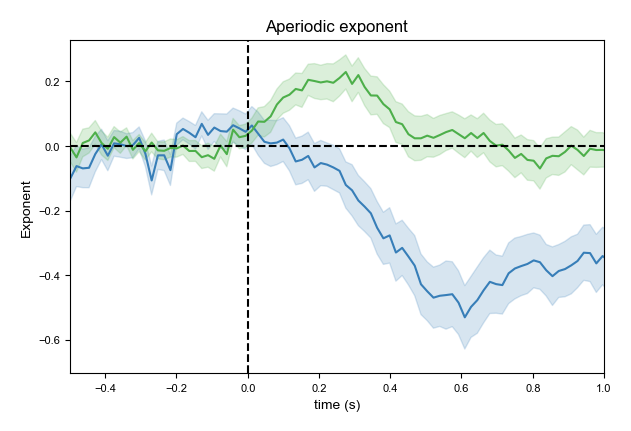

In [15]:
# plot
fig, ax = plt.subplots(1,1, figsize=[6,4])
fig.patch.set_facecolor('white')
for i_cond, color in zip(range(len(CHAN_IDX)), [RGB[2], RGB[1]]):
    # plot
    mean = np.nanmean(exp_list[i_cond], axis=0)
    sem = np.nanstd(exp_list[i_cond], axis=0) / np.sqrt(exp_list[i_cond].shape[0])
    ax.plot(time, mean, color=color)
    ax.fill_between(time, mean-sem, mean+sem, color=color, alpha=0.2)

# label
ax.set(xlabel=f'time (s)', ylabel=f'Exponent')
ax.set_title('Aperiodic exponent')
ax.axhline(0, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')
ax.set_xlim(T_TRIM)
plt.show()


### Plot figure - version 1

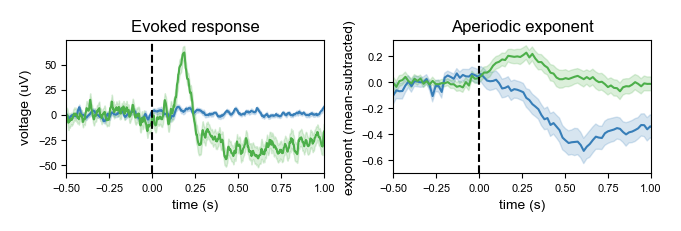

In [16]:
# combine ERP and exponent plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[6.5,2])
fig.patch.set_facecolor('white')

for i_cond, color in zip(range(len(CHAN_IDX)), [RGB[2], RGB[1]]):
    # plot erp
    mean = np.nanmean(erp_list[i_cond], axis=0)
    sem = np.nanstd(erp_list[i_cond], axis=0) / np.sqrt(erp_list[i_cond].shape[0])
    ax1.plot(erp_time, mean, color=color)
    ax1.fill_between(erp_time, mean-sem, mean+sem, color=color, alpha=0.2)

    # plot exponent
    mean = np.nanmean(exp_list[i_cond], axis=0)
    sem = np.nanstd(exp_list[i_cond], axis=0) / np.sqrt(exp_list[i_cond].shape[0])
    ax2.plot(time, mean, color=color)
    ax2.fill_between(time, mean-sem, mean+sem, color=color, alpha=0.2)

# label ax1
ax1.set(xlabel=f'time (s)', ylabel=f'voltage (uV)')
ax1.set_title('Evoked response')

# label ax2
ax2.set(xlabel=f'time (s)', ylabel=f'exponent (mean-subtracted)')
ax2.set_title('Aperiodic exponent')

# format axes
for ax in [ax1, ax2]:
    ax.axvline(0, color='k', linestyle='--')
    ax.set_xlim(T_TRIM)

# save
plt.savefig(f"{path_out}/erp_v_rotation_v1.png", dpi=300)

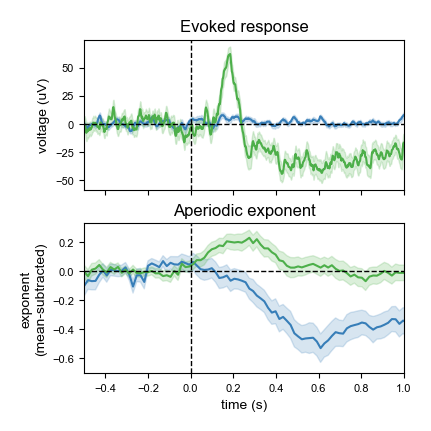

In [18]:
# combine ERP and exponent plots
fig, (ax1, ax2) = plt.subplots(2,1, figsize=[4, 4], sharex=True)
fig.patch.set_facecolor('white')

for i_cond, color in zip(range(len(CHAN_IDX)), [RGB[2], RGB[1]]):
    for var_list, time, ax in zip([erp_list, exp_list], [erp_time, time], [ax1, ax2]):
        mean = np.nanmean(var_list[i_cond], axis=0)
        sem = np.nanstd(var_list[i_cond], axis=0) / np.sqrt(var_list[i_cond].shape[0])
        ax.plot(time, mean, color=color)
        ax.fill_between(time, mean-sem, mean+sem, color=color, alpha=0.2)

# label ax1
ax1.set(ylabel=f'voltage (uV)')
ax1.set_title('Evoked response')

# label ax2
ax2.set(xlabel=f'time (s)', ylabel=f'exponent\n(mean-subtracted)')
ax2.set_title('Aperiodic exponent')

# format axes
for ax in [ax1, ax2]:
    ax.axvline(0, color='k', linestyle='--', linewidth=1)
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.set_xlim(T_TRIM)

# save
plt.savefig(f"{path_out}/erp_v_rotation_v2.png", dpi=300)

### Plot figure - version 2
plot channels separately 

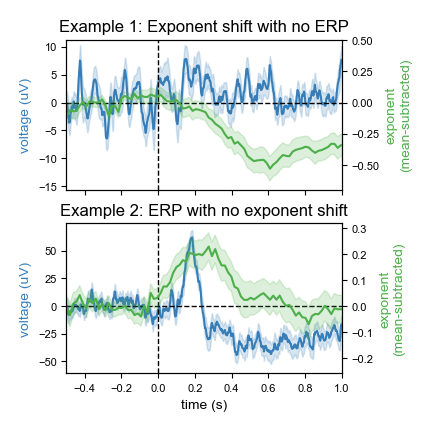

In [19]:
# combine ERP and exponent plots

# creat fig and axes
fig, (ax1, ax2) = plt.subplots(2,1, figsize=[4,4], sharex=True)
fig.patch.set_facecolor('white')
ax1b = ax1.twinx()
ax2b = ax2.twinx()

# plot each condition
for i_cond, ax, axb in zip(range(len(CHAN_IDX)), [ax1, ax2], [ax1b, ax2b]):
    # plot erp
    mean = np.nanmean(erp_list[i_cond], axis=0)
    sem = np.nanstd(erp_list[i_cond], axis=0) / np.sqrt(erp_list[i_cond].shape[0])
    l_erp = ax.plot(erp_time, mean, color=RGB[2])
    ax.fill_between(erp_time, mean-sem, mean+sem, color=RGB[2], alpha=0.2)

    # plot exponent
    mean = np.nanmean(exp_list[i_cond], axis=0)
    sem = np.nanstd(exp_list[i_cond], axis=0) / np.sqrt(exp_list[i_cond].shape[0])
    l_exp = axb.plot(time, mean, color=RGB[1])
    axb.fill_between(time, mean-sem, mean+sem, color=RGB[1], alpha=0.2)

# label and annotate
for ax, axb in zip([ax1, ax2], [ax1b, ax2b]):
    ax.axvline(0, color='k', linestyle='--', linewidth=1)
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.set_xlim(T_TRIM)
    ax.set_ylabel(f'voltage (uV)', color=RGB[2])
    axb.set_ylabel(f'exponent\n(mean-subtracted)', color=RGB[1])
ax2.set(xlabel=f'time (s)')
ax1.set_title('Example 1: Exponent shift with no ERP')
ax2.set_title('Example 2: ERP with no exponent shift')

# align y axes
align_yaxis(ax1, ax1b)
align_yaxis(ax2, ax2b)

# save
plt.savefig(f"{path_out}/erp_v_rotation_v3.png", dpi=300)